In [19]:
mannual_pathways = [
# CHOL
"MSigDB_Hallmark_2020__Oxidative Phosphorylation",
"MSigDB_Hallmark_2020__Xenobiotic Metabolism",
"MSigDB_Hallmark_2020__Fatty Acid Metabolism",
"MSigDB_Hallmark_2020__Bile Acid Metabolism",
"MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition",

# COADREAD
"Reactome_2022__Respiratory Electron Transport R-HSA-611105",
"Reactome_2022__Respiratory Electron Transport, ATP Synthesis By Chemiosmotic Coupling, Heat Production By Uncoupling Proteins R-HSA-163200",
"KEGG_2021_Human__Oxidative phosphorylation",
"MSigDB_Hallmark_2020__Oxidative Phosphorylation",
"Reactome_2022__Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517",

# KICH
"KEGG_2021_Human__Herpes simplex virus 1 infection",
"MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition",

# THYM
"Reactome_2022__Selenoamino Acid Metabolism R-HSA-2408522",
"Reactome_2022__Peptide Chain Elongation R-HSA-156902",
"KEGG_2021_Human__Ribosome",
"Reactome_2022__Eukaryotic Translation Elongation R-HSA-156842",
"Reactome_2022__Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC) R-HSA-975956",

]

Top 20 common names: ['Reactome_2022__Mitotic Prometaphase R-HSA-68877', 'Reactome_2022__Resolution Of Sister Chromatid Cohesion R-HSA-2500257', 'Reactome_2022__APC/C-mediated Degradation Of Cell Cycle Proteins R-HSA-174143', 'Reactome_2022__Activation Of APC/C And APC/C:Cdc20 Mediated Degradation Of Mitotic Proteins R-HSA-176814', 'Reactome_2022__APC/C:Cdc20 Mediated Degradation Of Mitotic Proteins R-HSA-176409', 'Reactome_2022__DNA Strand Elongation R-HSA-69190', 'MSigDB_Hallmark_2020__Oxidative Phosphorylation', 'Reactome_2022__DNA Replication R-HSA-69306', 'MSigDB_Hallmark_2020__Fatty Acid Metabolism', 'Reactome_2022__Peptide Chain Elongation R-HSA-156902', 'Reactome_2022__HDR Thru Homologous Recombination (HRR) R-HSA-5685942', 'Reactome_2022__Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517', 'KEGG_2021_Human__Ribosome', 'MSigDB_Hallmark_2020__Xenobiotic Metabolism', 'MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition', 'Reactome_2022__Nonsense Mediate

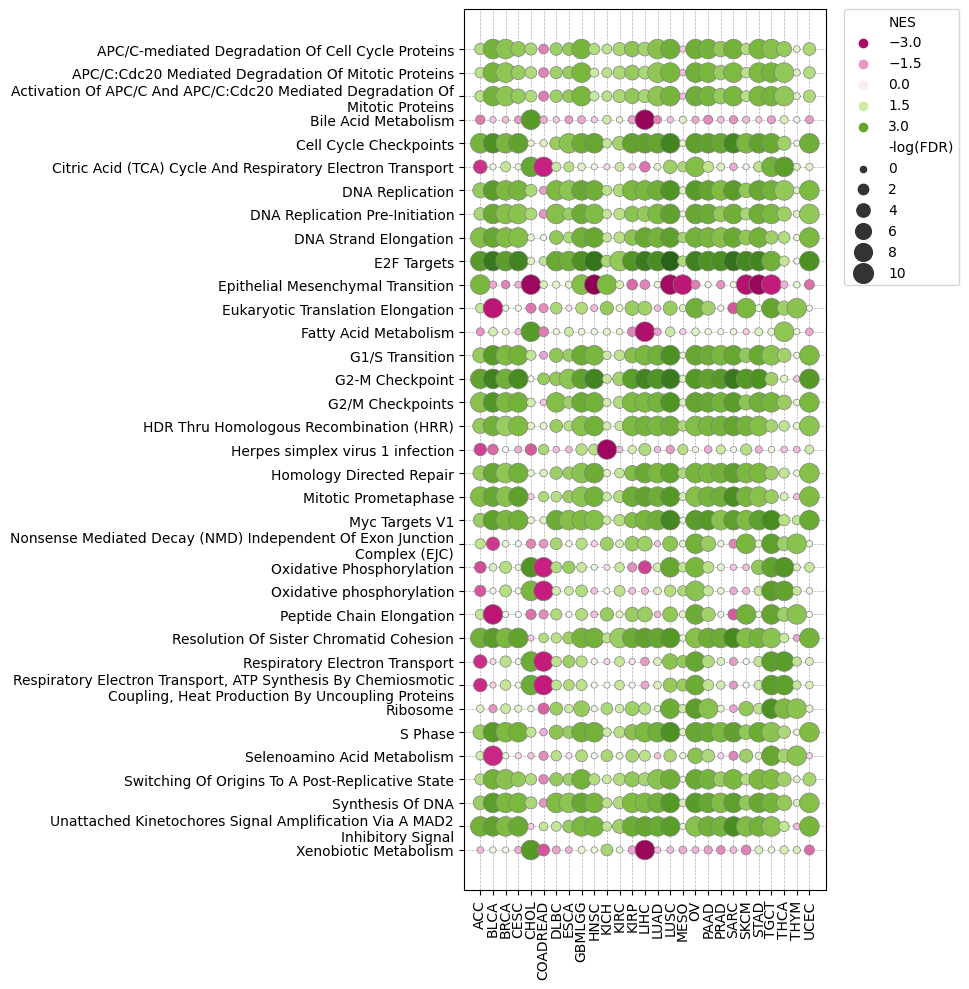

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from collections import defaultdict

# Load data
invalid_studies = ["PCPG", "UCS"]
root = "results_final/gene/dseq_results"
studies = sorted([study for study in os.listdir(root) if os.path.isdir(os.path.join(root, study)) and study not in invalid_studies])
df_lists = []
lists = []

for study in studies:
    df = pd.read_csv(f"{root}/{study}/gseapy.gene_set.prerank.report.csv")
    df_lists.append(df)
    lists.append(df["Term"].to_list())

# Find common names across all lists
common_names = set(lists[0])
for lst in lists[1:]:
    common_names &= set(lst)

# Create a dictionary to store the ranks of common names
name_ranks = defaultdict(list)

# Populate the dictionary with ranks from each list
for i, lst in enumerate(lists):
    for rank, name in enumerate(lst):
        if name in common_names:
            name_ranks[name].append(rank)

# Calculate the average rank for each common name
average_ranks = {name: np.mean(ranks) for name, ranks in name_ranks.items()}

# Sort the names by their average rank
sorted_names = sorted(average_ranks, key=average_ranks.get)

# Select the top 20 names
top_20_names = sorted_names[:20]

top_20_names = top_20_names + mannual_pathways
top_20_names = list(set(top_20_names))

print("Top 20 common names:", top_20_names)

# Function to clean term names
def clean_term(term):
    parts = term.split("__")
    main_term = parts[1] if len(parts) > 1 else term
    if parts[0] == "Reactome_2022" and "R-HSA-" in main_term:
        main_term = main_term.split("R-HSA-")[0].strip()
    return "\n".join(textwrap.wrap(main_term, width=65))

# Prepare data for plotting
plot_data = []

for study, df in zip(studies, df_lists):
    df_filtered = df[df["Term"].isin(top_20_names)].copy()
    df_filtered["-log(FDR)"] = -np.log10(df_filtered["FDR q-val"].replace(0, 1e-10))
    df_filtered["Study"] = study
    df_filtered["Clean_Term"] = df_filtered["Term"].apply(clean_term)
    plot_data.append(df_filtered.sort_values(by="Clean_Term"))

plot_data = pd.concat(plot_data)
# plot_data = plot_data.sort_values(by="Clean_Term")

# Plot the dotplot
# plt.figure(figsize=(10, 6))
fig, ax =plt.subplots(1,1,figsize=(10, 10))
dotplot = sns.scatterplot(
    data=plot_data,
    x="Study",
    y="Clean_Term",
    size="-log(FDR)",
    hue="NES",
    palette="PiYG",
    sizes=(20, 200),
    edgecolor="gray",
    linewidth=0.5,
    ax=ax
)

dotplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
# plt.title('Dotplot of Top Common Terms across Studies')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_axisbelow(True)

plt.tight_layout()

plt.savefig(f"{root}/dseq_results_all.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
plt.savefig(f"{root}/dseq_results_all.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)